In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

from src.accelerometer import plot_fourier_transformation, plot_acceleration, plot_feature_columns, accelerometer_feature_engineering
from src.kmeans import kmeans
from src.principal_component_analysis import principal_component_analysis, plot_principal_component_analysis
from src.decision_tree import decision_tree
from src.device_handling import split_by_device
from src.plotting import box_plot_columns

In [2]:
drift_df = pd.read_csv('drift_accelerations.csv')
drift_df = drift_df[drift_df['age_group']!=0]

In [3]:
drift_df.head(5)

,subject,age_group,file,uuid,hand,device,time_stamp,duration,x,y,z,mag
2496,50-01-01,50,6b718035-3d80-4520-91fb-60817780d706.json,6b718035-3d80-4520-91fb-60817780d706,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,1670259880948,0,-1306,-2622,2030,3563.905161
2497,50-01-01,50,6b718035-3d80-4520-91fb-60817780d706.json,6b718035-3d80-4520-91fb-60817780d706,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,1670259880974,26,-914,-3102,2752,4246.328296
2498,50-01-01,50,6b718035-3d80-4520-91fb-60817780d706.json,6b718035-3d80-4520-91fb-60817780d706,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,1670259881004,56,-902,-3310,3486,4891.001942
2499,50-01-01,50,6b718035-3d80-4520-91fb-60817780d706.json,6b718035-3d80-4520-91fb-60817780d706,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,1670259881065,117,-1296,-3222,4118,5386.912288
2500,50-01-01,50,6b718035-3d80-4520-91fb-60817780d706.json,6b718035-3d80-4520-91fb-60817780d706,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,1670259881094,146,-2108,-3168,3506,5174.159255


In [4]:
drift_df.describe()

,age_group,time_stamp,duration,x,y,z,mag
count,162869.000000,1.628690e+05,162869.000000,162869.000000,162869.00000,162869.000000,162869.000000
mean,40.161295,1.670701e+12,37396.527246,-2295.392150,262.74003,-3272.436572,4403.188773
std,9.998730,3.234096e+08,30642.154510,596.758832,1525.26788,864.759837,298.294245
min,30.000000,1.670254e+12,0.000000,-9918.000000,-7192.00000,-8786.000000,347.182949
25%,30.000000,1.670261e+12,13976.000000,-2720.000000,-1098.00000,-3802.000000,4228.418617
50%,50.000000,1.670853e+12,27958.000000,-2350.000000,158.00000,-3354.000000,4401.520646
75%,50.000000,1.670959e+12,61585.000000,-1934.000000,1662.00000,-2798.000000,4592.664151
max,50.000000,1.671128e+12,128364.000000,6068.000000,12638.00000,6214.000000,13691.329081


In [5]:
single_session_df = drift_df[drift_df['uuid'] == drift_df['uuid'].unique()[1]]

In [6]:
single_sessions_devices_df = split_by_device(single_session_df)

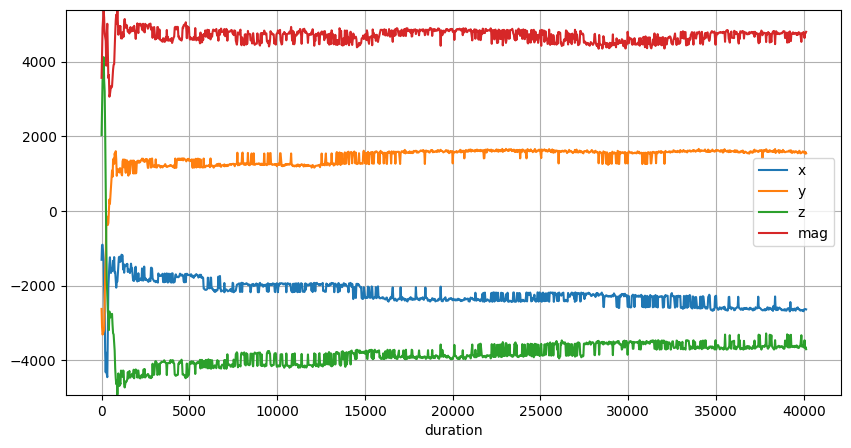

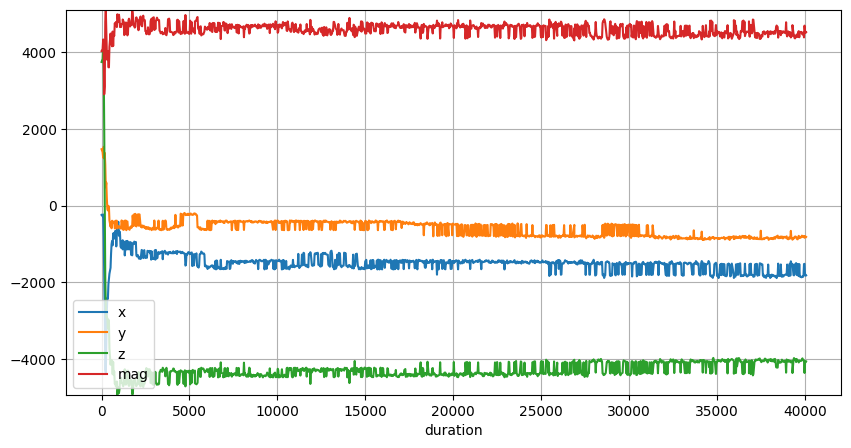

In [7]:
plot_acceleration(single_sessions_devices_df, subplots=False)

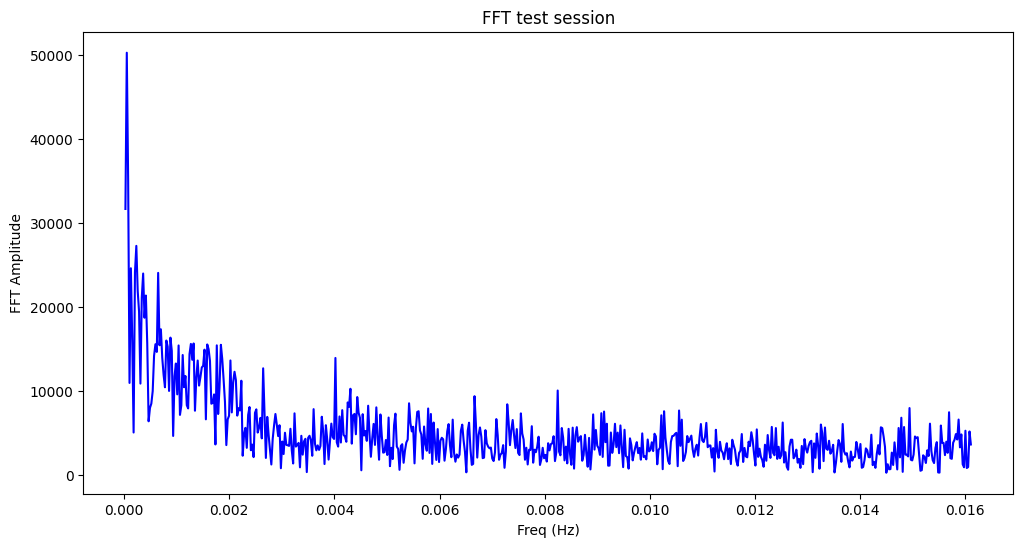

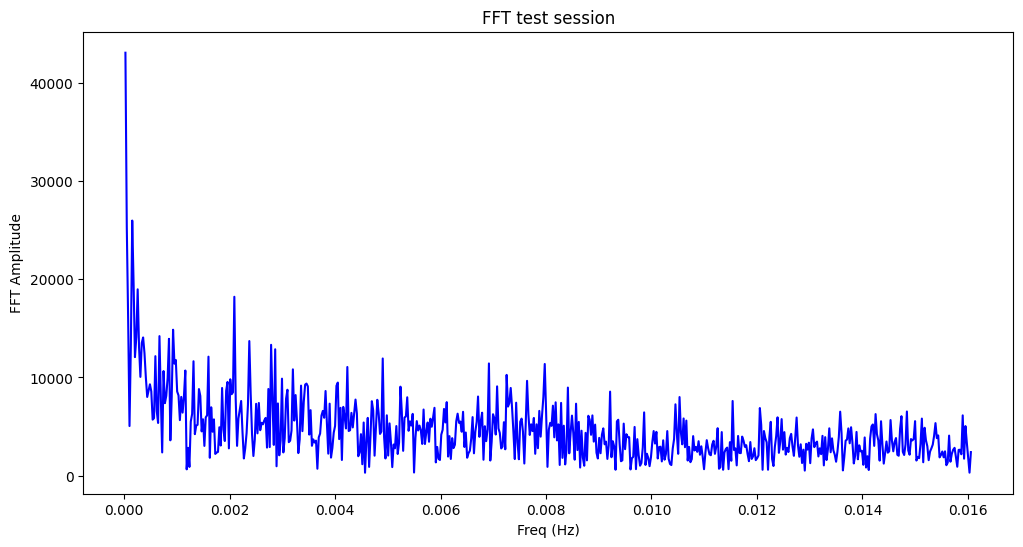

In [8]:
plot_fourier_transformation(single_sessions_devices_df, 'test session')

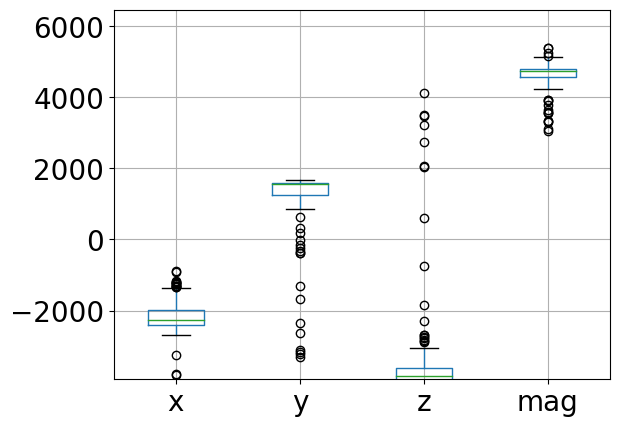

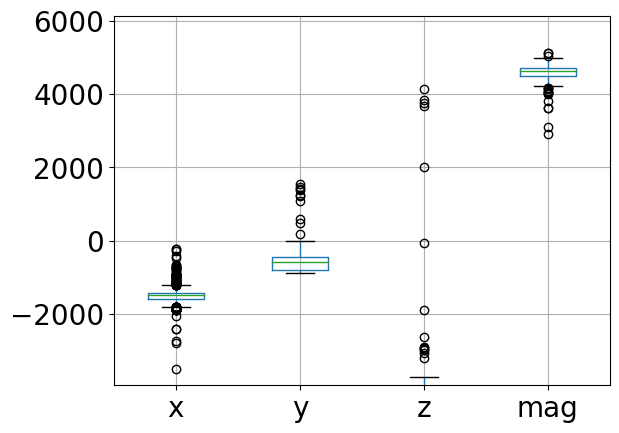

In [9]:
box_plot_columns(single_sessions_devices_df)

In [10]:
def drift_features(df):
    entries = []
    for uuid in df['uuid'].unique():
        current_df = df[df['uuid'] == uuid]
        entry = {}
        entry['age_group'] = current_df['age_group'].unique().max()
        entry['subject'] = current_df['subject'].unique().any()
        entry['uuid'] = current_df['uuid'].unique().any()
        entry['file'] = current_df['file'].unique().any()
        entry['duration'] = current_df['duration'].max()
        session_devices = split_by_device(current_df)
        device_count = 0
        for device_df in session_devices:
            device_processed_df = accelerometer_feature_engineering(device_df)
            device_processed_df = device_processed_df.drop(columns=['x_sem', 'y_sem', 'z_sem', 'mag_sem','duration'])
            suffix = f'_{device_count}'
            device_count += 1
            device_processed_df.columns += suffix
            for column in device_processed_df.columns:
                entry[column]=device_processed_df[column].max()
        entries.append(entry)
    return pd.DataFrame(entries)

In [11]:
def calc_device_diffs(df, columns):
    local_df = df.copy()
    new_suffix = '_diff'
    processed_columns = []
    for column in columns:
        column_without_suffix = column.removesuffix('_0').removesuffix('_1')
        if column_without_suffix not in processed_columns:
            processed_columns.append(column_without_suffix)
            new_column = column_without_suffix + new_suffix
            column_device_1 = column_without_suffix+'_0'
            column_device_2 = column_without_suffix+'_1'
            local_df[new_column] = local_df[column_device_1]-local_df[column_device_2]
            local_df = local_df.drop(columns=[column_device_1, column_device_2])
    return local_df

In [12]:
feature_device_based_df = drift_features(drift_df)
feature_device_based_df = calc_device_diffs(feature_device_based_df,feature_device_based_df.columns[5:])
feature_device_based_df.head()

,age_group,subject,uuid,file,duration,x_std_diff,y_std_diff,z_std_diff,mag_std_diff,x_mean_diff,...,z_peaks_diff,mag_peaks_diff,x_sal_diff,y_sal_diff,z_sal_diff,mag_sal_diff,x_snr_diff,y_snr_diff,z_snr_diff,mag_snr_diff
0,50,50-01-01,6b718035-3d80-4520-91fb-60817780d706,6b718035-3d80-4520-91fb-60817780d706.json,108051,32.899415,162.497219,7.153854,23.267602,-542.308810,...,-9,8,0.085896,-0.156092,-0.181221,-0.019147,-1.153656,6.752413,0.568276,-1.484241
1,50,50-01-01,a4028481-8728-40b8-af4b-e96150551693,a4028481-8728-40b8-af4b-e96150551693.json,40132,75.718680,148.723239,58.206537,29.724268,-716.087560,...,5,4,0.062794,0.069675,-0.063412,-0.018571,-0.799894,6.078823,1.498008,-3.799146
2,50,50-01-01,e6a14767-4d33-40d8-a5f7-dcb9b273110b,e6a14767-4d33-40d8-a5f7-dcb9b273110b.json,40164,60.317003,62.779698,88.385670,23.924799,-1259.039173,...,9,11,0.508401,0.852732,-0.030667,0.011343,-2.977699,6.394685,3.187309,-4.104924
3,50,50-01-01,e045f3a3-49c2-4a5c-a0a0-61f27cca2886,e045f3a3-49c2-4a5c-a0a0-61f27cca2886.json,103580,54.152356,135.240129,123.744476,52.480784,-1180.521222,...,12,10,0.433249,0.439363,-0.185094,0.081089,-2.844576,5.897098,3.984699,-5.844204
4,50,50-01-01,6a1aeabd-567c-4b58-b193-4032d303d2c6,6a1aeabd-567c-4b58-b193-4032d303d2c6.json,40104,132.690395,40.930016,221.518190,63.914330,-531.620697,...,-9,-6,0.327793,0.228380,0.079146,0.015517,1.932682,8.664542,11.726426,-11.800326


In [13]:
pd.set_option('display.max_columns', None)
feature_device_based_df.corr(numeric_only=True)

,age_group,duration,x_std_diff,y_std_diff,z_std_diff,mag_std_diff,x_mean_diff,y_mean_diff,z_mean_diff,mag_mean_diff,x_peaks_diff,y_peaks_diff,z_peaks_diff,mag_peaks_diff,x_sal_diff,y_sal_diff,z_sal_diff,mag_sal_diff,x_snr_diff,y_snr_diff,z_snr_diff,mag_snr_diff
age_group,1.000000,-0.035925,0.084719,-0.022421,0.098181,0.013585,-0.505259,0.003022,0.478523,-0.535139,0.016617,-0.035983,0.077363,0.099894,0.279348,0.299017,-0.172627,-0.074515,-0.314522,-0.447672,0.058821,-0.220148
duration,-0.035925,1.000000,-0.107857,-0.094863,-0.225153,0.007380,0.038411,-0.004099,-0.090288,0.060641,0.269566,0.023220,0.056870,0.290849,0.019686,-0.043858,-0.159882,0.088476,-0.118846,-0.192793,-0.356981,0.008596
x_std_diff,0.084719,-0.107857,1.000000,0.109204,-0.039094,0.006342,-0.476202,-0.066206,0.308059,-0.329964,-0.188317,0.195931,-0.187739,-0.231452,0.053736,-0.155409,0.050199,-0.030322,0.618407,-0.072472,0.259536,-0.096169
y_std_diff,-0.022421,-0.094863,0.109204,1.000000,-0.161690,0.538842,-0.138865,-0.063022,0.207960,-0.106363,-0.289923,-0.135195,0.058335,-0.074041,0.254332,-0.218163,-0.100246,-0.164776,0.025606,-0.129124,-0.015012,-0.462837
z_std_diff,0.098181,-0.225153,-0.039094,-0.161690,1.000000,-0.146539,0.099405,-0.021261,-0.045279,0.002341,-0.128803,-0.154264,-0.083896,-0.298826,0.071088,-0.044778,-0.109016,0.077215,0.042471,0.063688,0.686888,0.032288
mag_std_diff,0.013585,0.007380,0.006342,0.538842,-0.146539,1.000000,-0.003725,0.016321,0.129975,-0.004376,-0.052478,0.235344,0.191004,0.037038,0.253862,0.156949,-0.144033,-0.255284,0.011950,-0.211677,-0.109036,-0.911817
x_mean_diff,-0.505259,0.038411,-0.476202,-0.138865,0.099405,-0.003725,1.000000,0.106907,-0.767540,0.792488,0.019296,-0.236178,-0.056655,0.269738,-0.308191,0.074788,0.057922,0.058566,0.230290,0.262642,-0.184983,0.164897
y_mean_diff,0.003022,-0.004099,-0.066206,-0.063022,-0.021261,0.016321,0.106907,1.000000,-0.173736,0.425984,-0.285131,-0.272513,-0.160830,-0.075778,-0.022103,-0.315216,-0.254474,0.003166,0.019948,0.482043,-0.199918,0.115168
z_mean_diff,0.478523,-0.090288,0.308059,0.207960,-0.045279,0.129975,-0.767540,-0.173736,1.000000,-0.914575,-0.167241,0.319175,0.127935,-0.376500,0.325402,-0.040692,-0.127762,-0.162869,-0.177432,-0.402377,0.182891,-0.319636
mag_mean_diff,-0.535139,0.060641,-0.329964,-0.106363,0.002341,-0.004376,0.792488,0.425984,-0.914575,1.000000,0.063354,-0.285317,-0.089072,0.287052,-0.231691,-0.046291,0.058701,0.120532,0.253353,0.513727,-0.185548,0.228582


/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


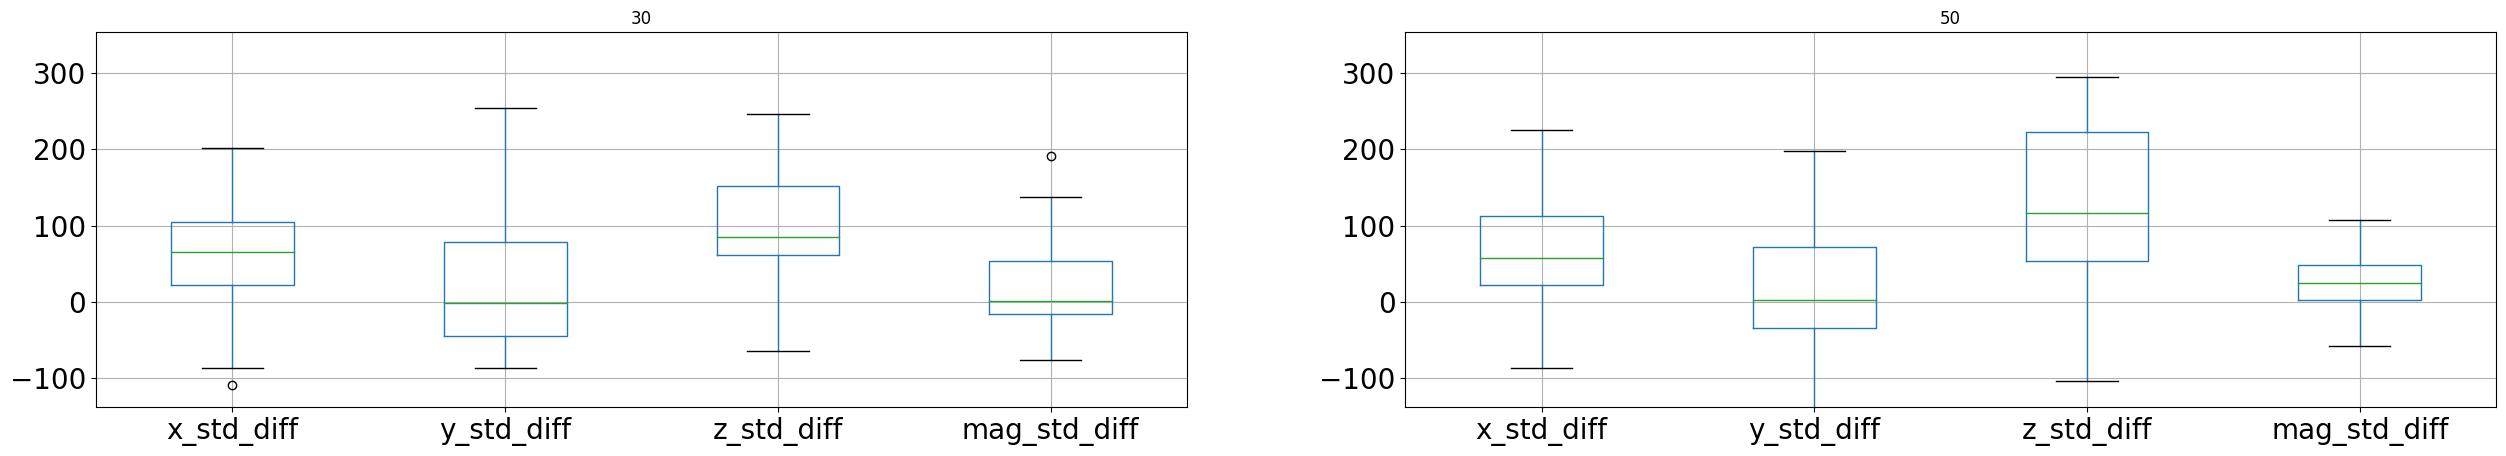

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


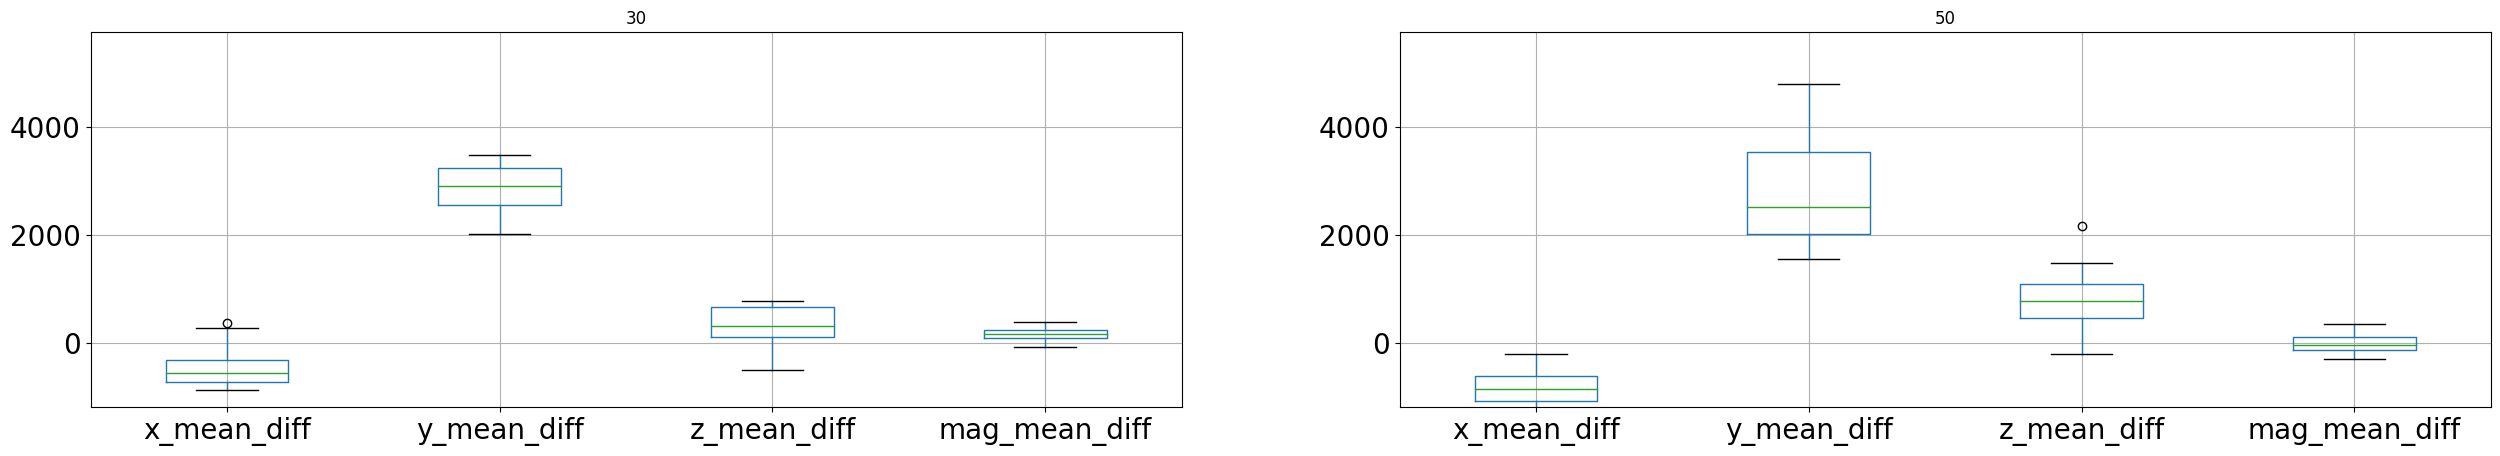

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


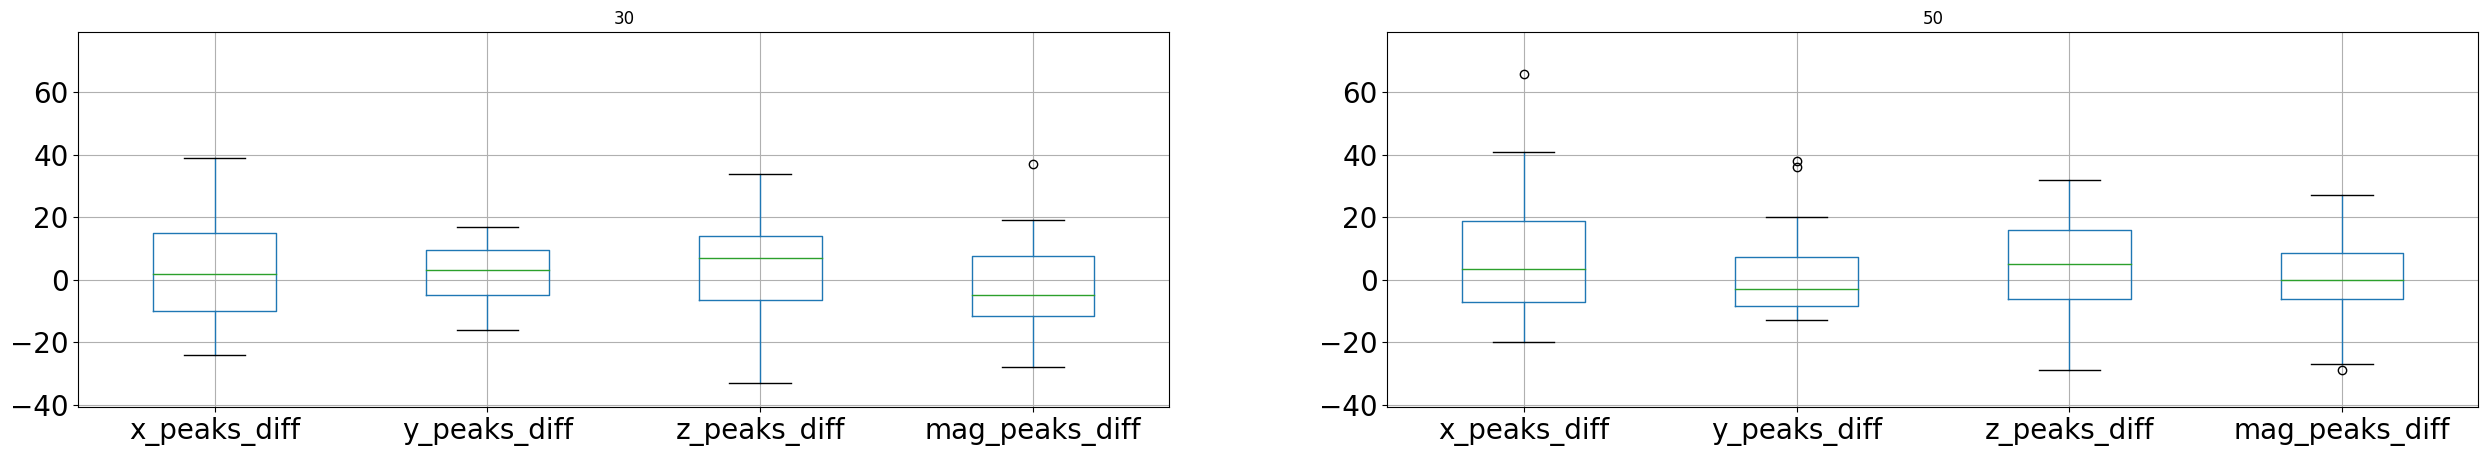

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


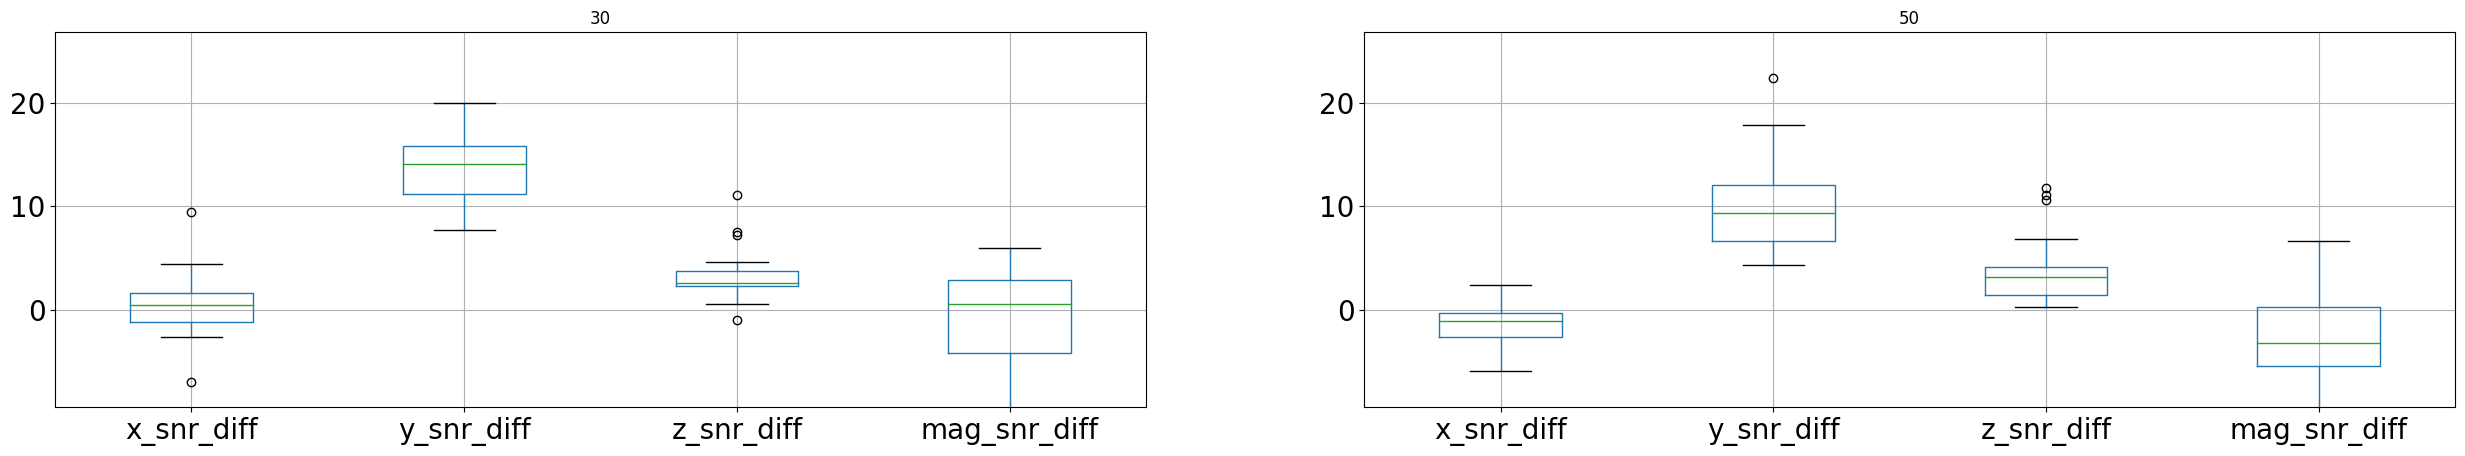

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


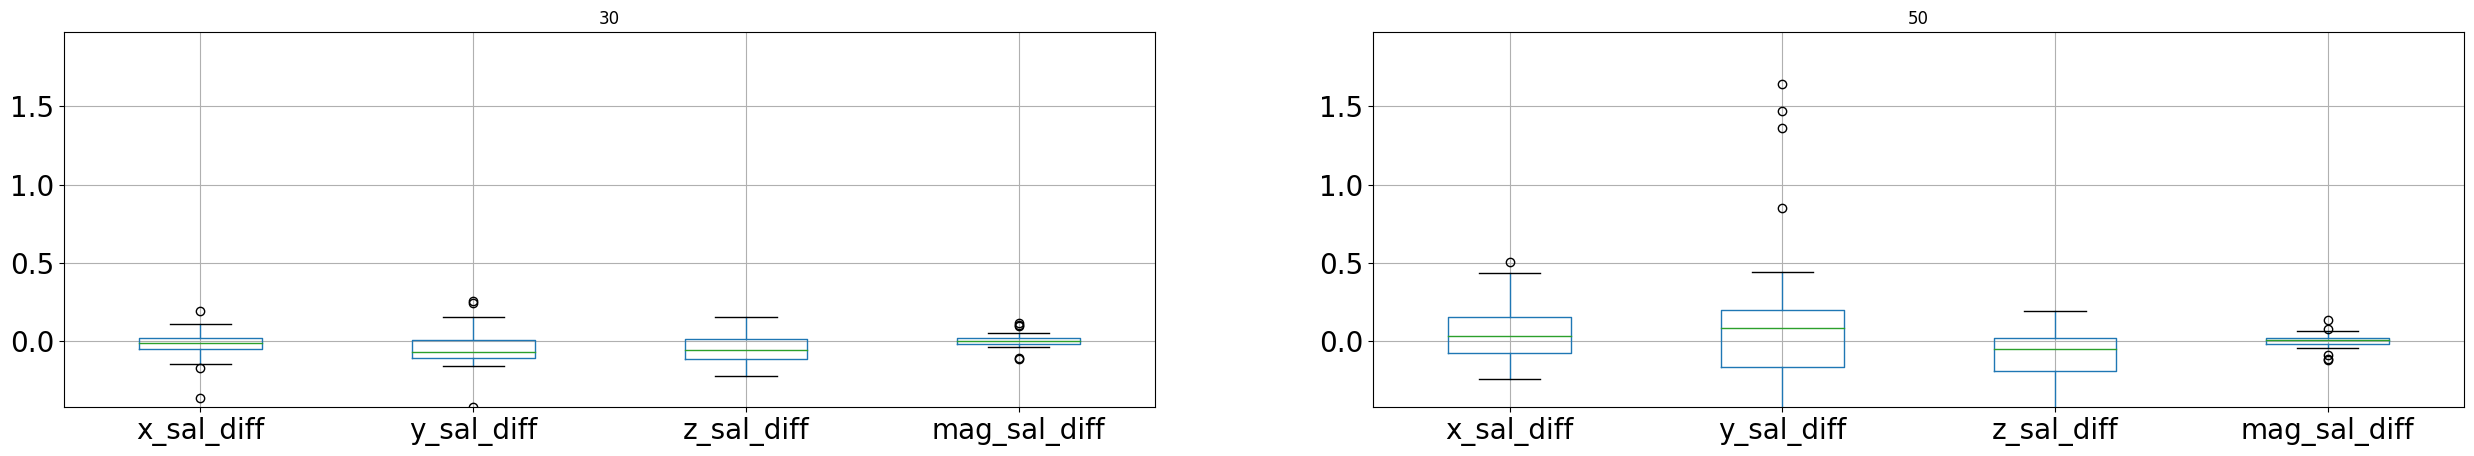

In [14]:
box_plot_columns(feature_device_based_df, 'age_group', ['x_std_diff','y_std_diff','z_std_diff','mag_std_diff'])
box_plot_columns(feature_device_based_df, 'age_group', ['x_mean_diff','y_mean_diff','z_mean_diff','mag_mean_diff'])
box_plot_columns(feature_device_based_df, 'age_group', ['x_peaks_diff','y_peaks_diff','z_peaks_diff','mag_peaks_diff'])
box_plot_columns(feature_device_based_df, 'age_group', ['x_snr_diff','y_snr_diff','z_snr_diff','mag_snr_diff'])
box_plot_columns(feature_device_based_df, 'age_group', ['x_sal_diff','y_sal_diff','z_sal_diff','mag_sal_diff'])

In [15]:
feature_df = accelerometer_feature_engineering(drift_df)
feature_df = feature_df.drop(columns=['x_sem', 'y_sem', 'z_sem', 'mag_sem'])
feature_df = feature_df.reset_index(drop=False)

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


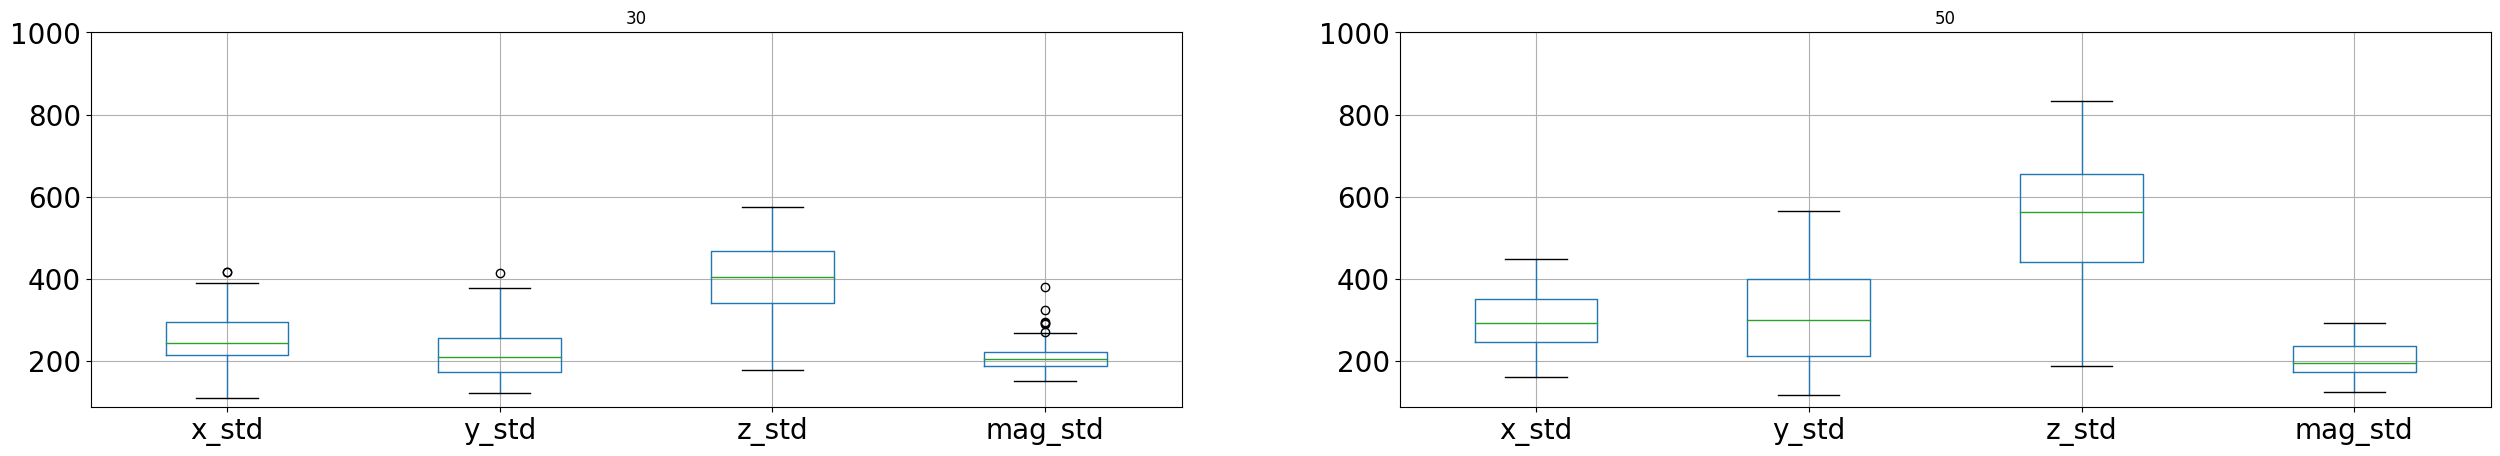

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


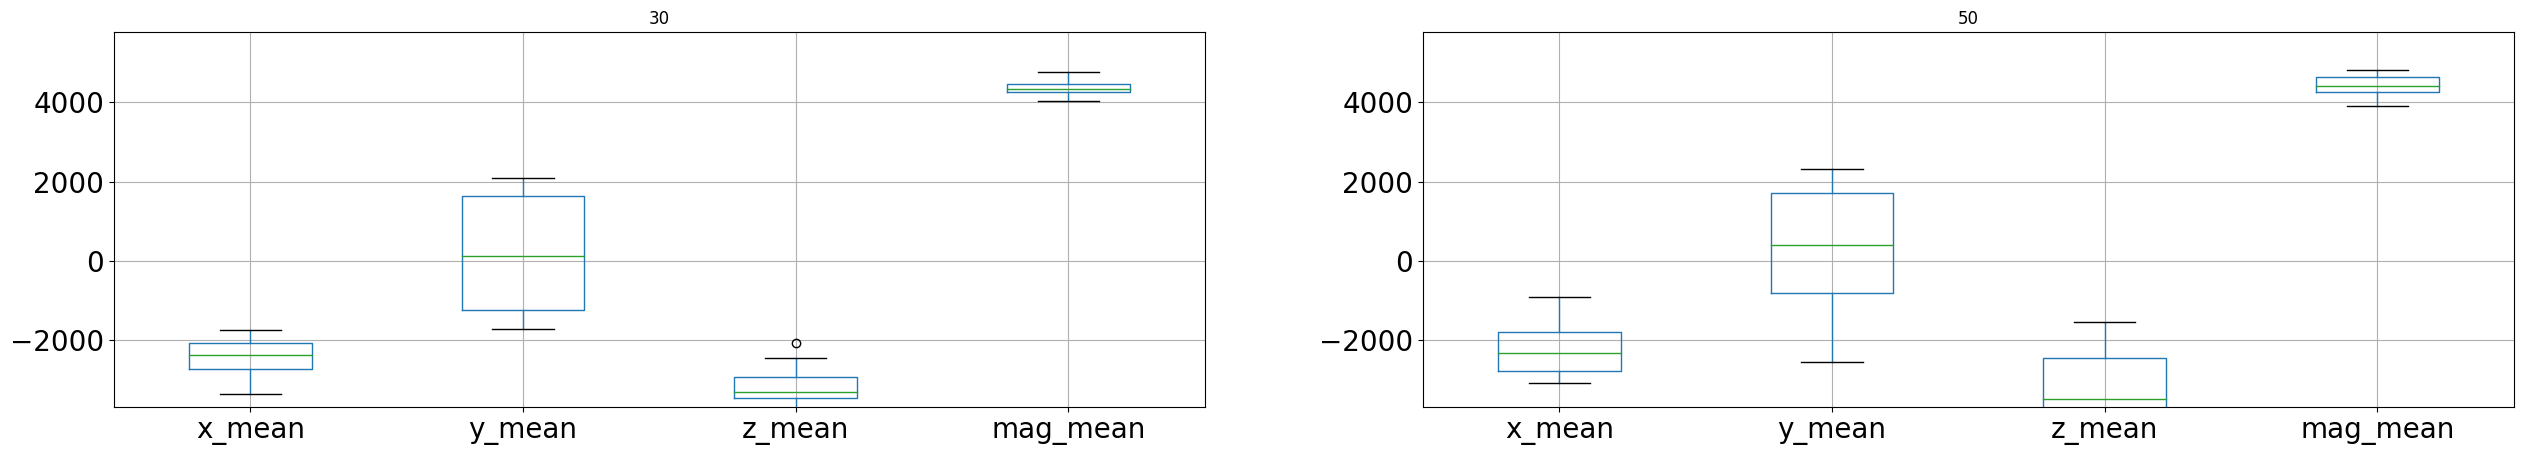

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


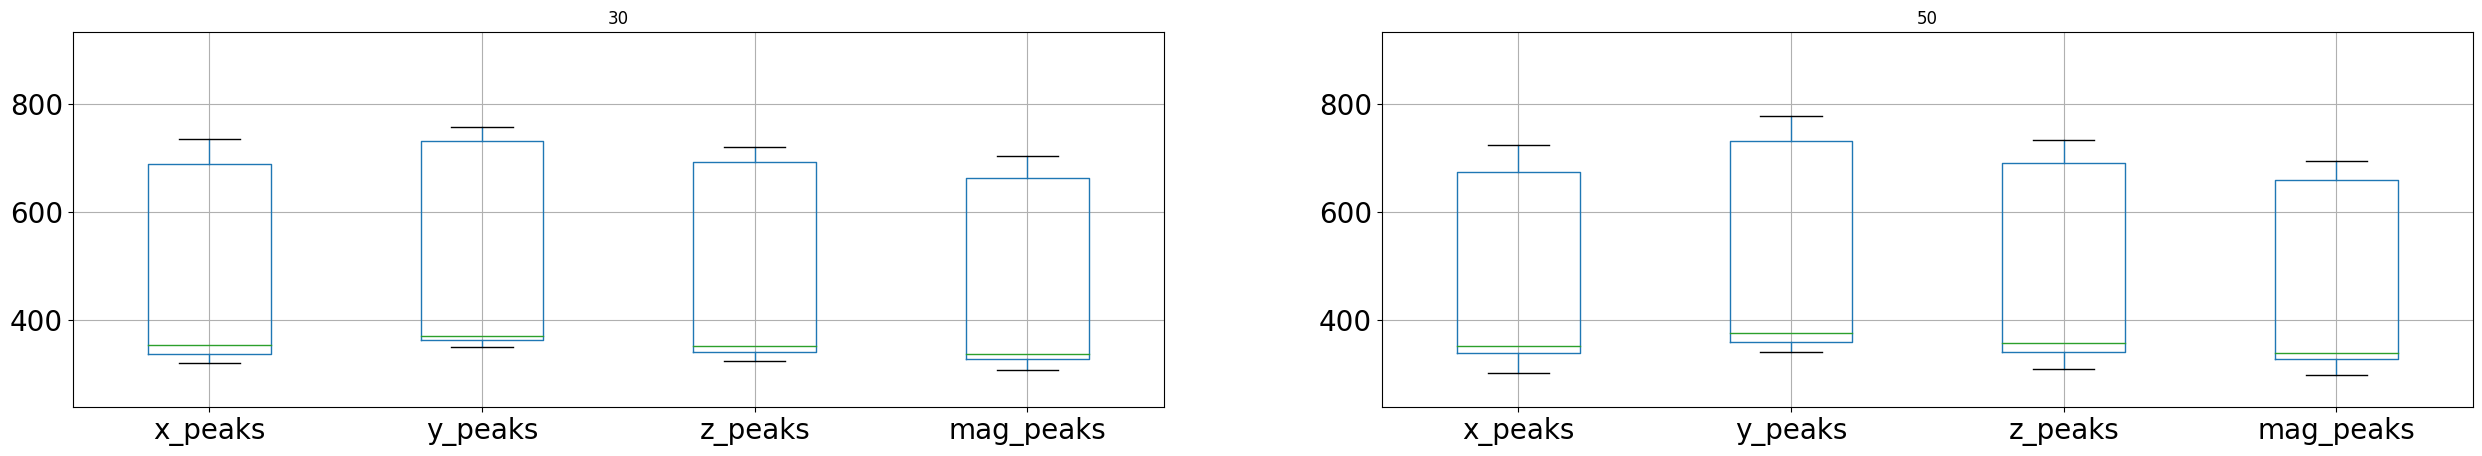

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


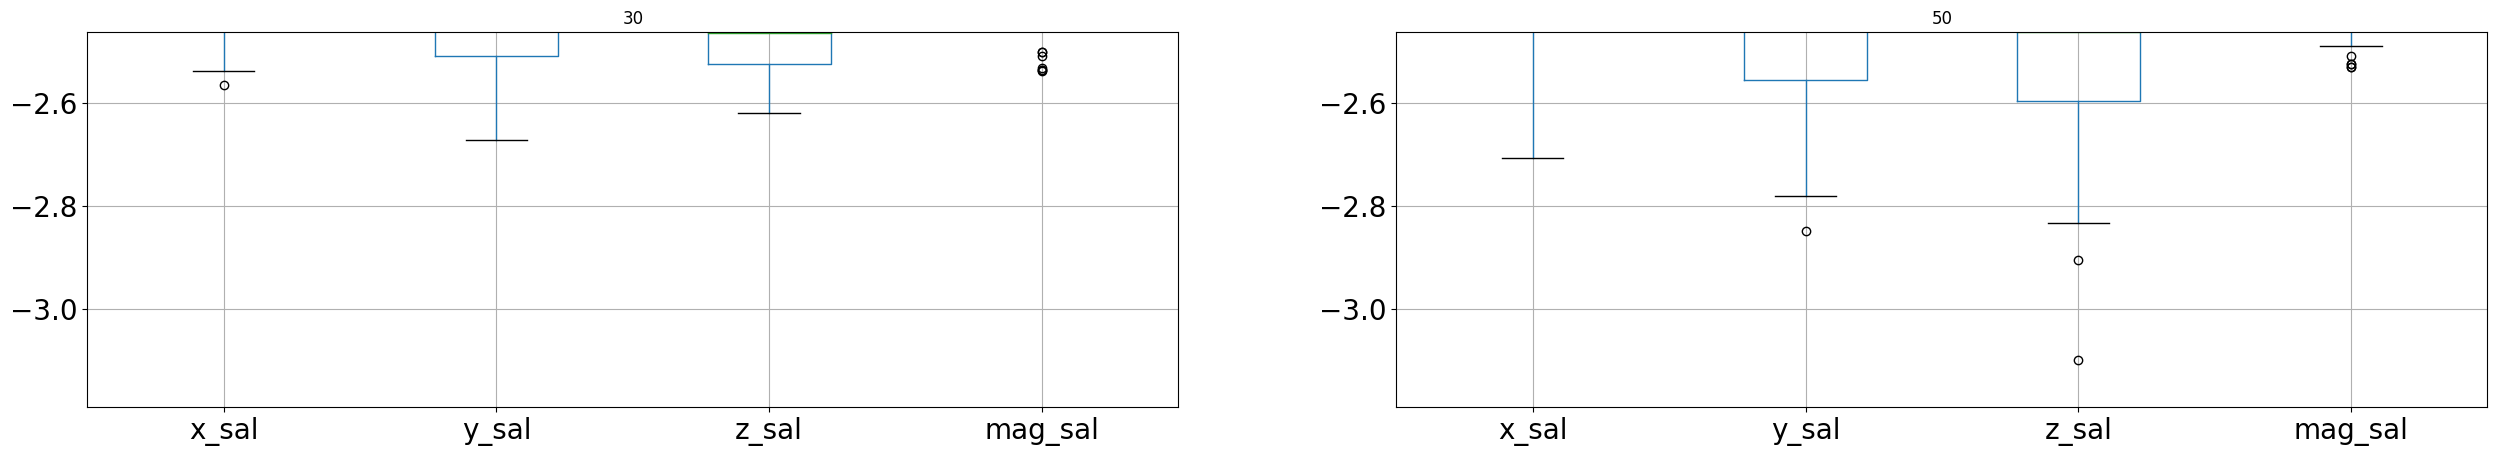

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/plotting.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  final_df.boxplot(fontsize=20, ax=ax)


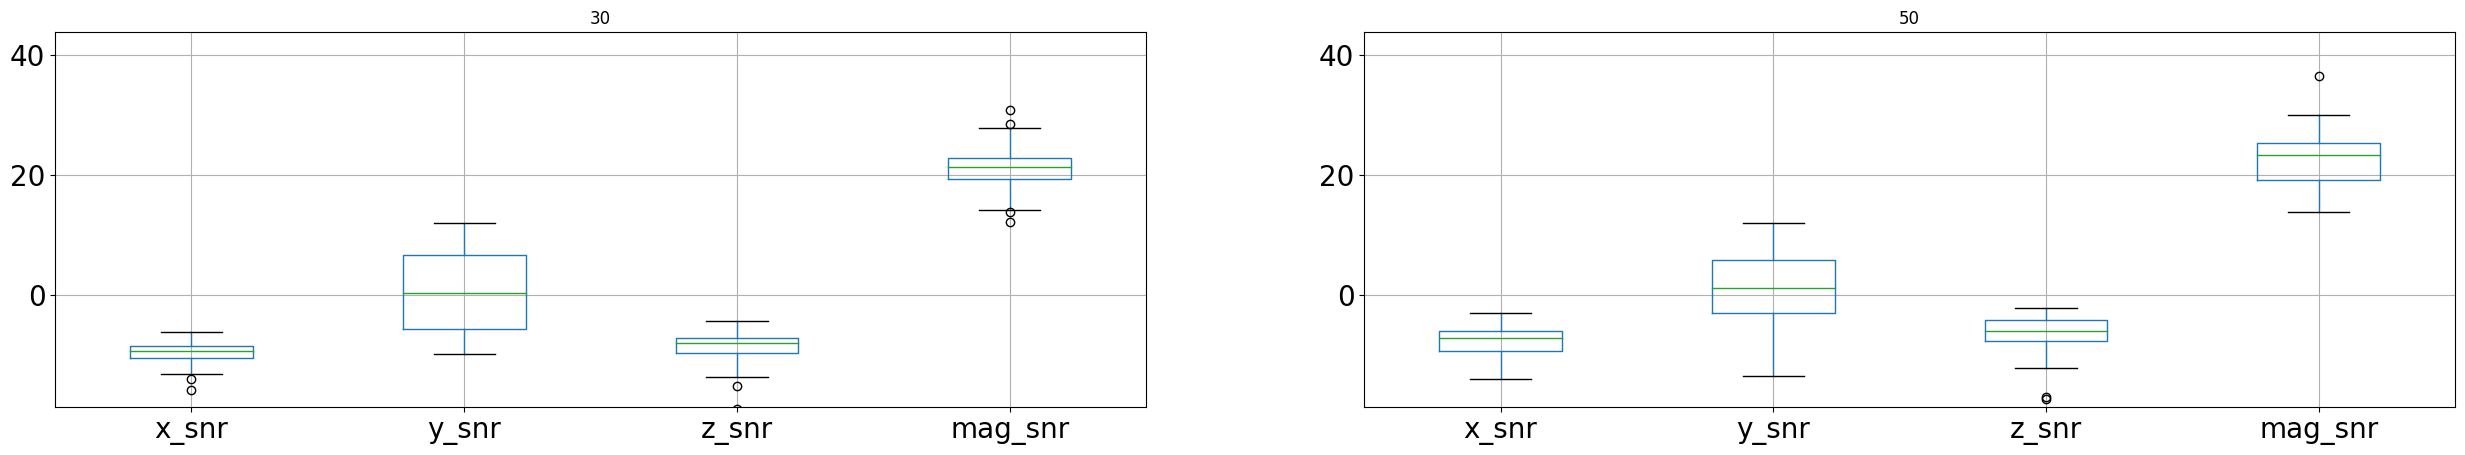

In [16]:
plot_feature_columns(feature_df,'std')
plot_feature_columns(feature_df,'mean')
plot_feature_columns(feature_df,'peaks')
plot_feature_columns(feature_df,'sal')
plot_feature_columns(feature_df,'snr')

In [17]:
merged_df = feature_df.merge(feature_device_based_df, on=['age_group','subject','uuid'])

In [18]:
feature_keys = ['z_std','y_std','z_std_diff']
class_key = ['age_group']

In [19]:
train_df, test_df = train_test_split(merged_df, test_size=0.10)

# Apply Kmeans Clustering

In [20]:
kmeans_model = kmeans(train_df, feature_keys)
kmeans_predicitons = kmeans_model.predict(test_df[feature_keys])
predictions_df = pd.DataFrame()
predictions_df['age_group'] = test_df['age_group']
predictions_df['cluster'] = kmeans_predicitons
predictions_df

,age_group,cluster
72,50,0
7,30,1
20,30,1
50,50,0
46,50,1
78,50,1
37,30,1
21,30,1
38,30,0
4,30,1


# Principal Component Analysis

In [21]:
principal_components_df = principal_component_analysis(merged_df, feature_keys)

<Figure size 640x480 with 0 Axes>

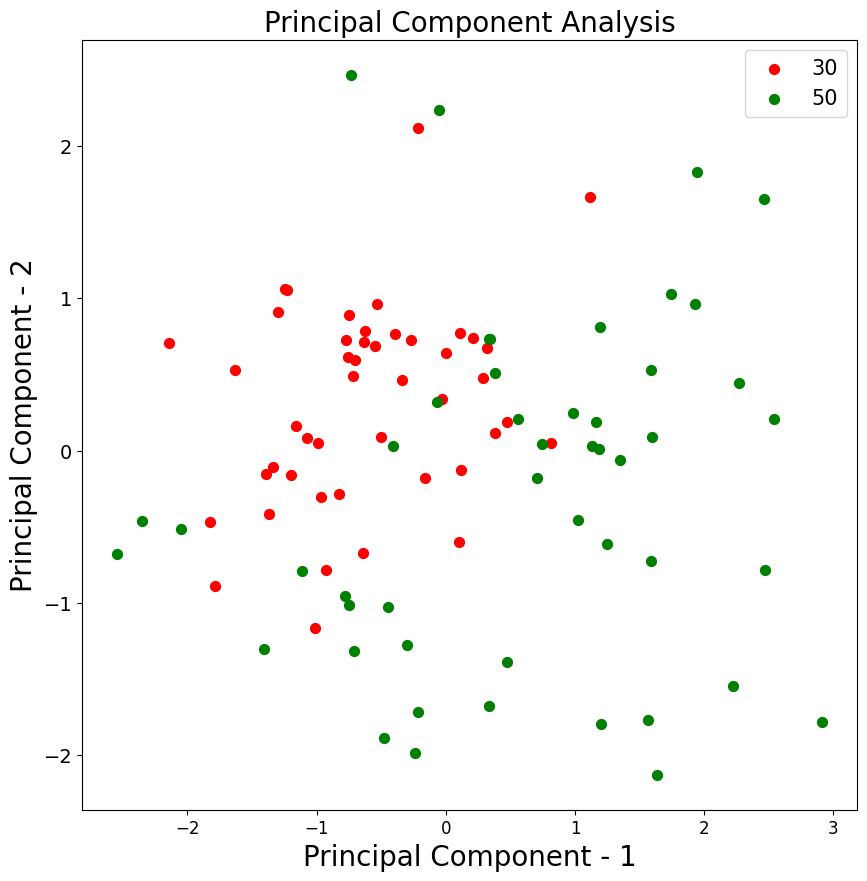

In [22]:
plot_principal_component_analysis(merged_df, principal_components_df, 'age_group', [30,50])

# Decision Tree

In [23]:
dt = decision_tree(train_df, feature_keys)

In [24]:
dt_predictions = dt.predict(test_df[feature_keys])
metrics.accuracy_score(test_df['age_group'], dt_predictions)

0.9